# 1. Motivation

We wish to investigate, how rain may affect the average tips received by yellow taxi drivers, but also use the text from wikipedia to explain, why some places are more attractive than others in New York City.

In this project, we have 3 data sets: TLC trip record data, weather data in New York City scraped from wunderground and text scraped from Wikipedia. Details on the data will be explained now:

TLC trip record data is yellow and green taxi trip records on fields including: tip, pick-up location/time and drop-off location/time. The data is accessible from the following link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page and you are able to download yellow and green taxi trip records for a given month between 2009 and 2024. The data downloaded from the website is in a format called Parquet, which can be imported into a panda dataframe easily. The locations are seperated into taxi zones, and the information regarding these can be downloaded from the same website. 

We chose to scrape the weather data from wunderground, because the website keeps weather history data, you can choose specific weather stations in New York City and finally, it was relatively easy to scrape due to the format of the url. This website uses JavaScript, so BeautifulSoup did not suffice and we resolved to another method using Selenium to scrape. The data we scraped came in tables, where the precipitation, wind, temperature and other weather relevant fields were recorded hourly from 1930 to 2024. There are many weather stations in New York City, so we resolved to using the default weather station with initials KLGA. The website has the following link: https://www.wunderground.com/history/daily/us/ny/new-york-city/KLGA/date/, where the data needs to be inputted after date/. 

To get a deeper insight into, why people take taxi trips from one location to another, we categorized the pick-up and drop-off locations based on the borough the taxi zones are in. Based on the 5 boroughs in New York City: Manhattan, Bronx, Staten Island, Brooklyn and Queens, we scraped their respective wikipedia page and also wikipedia pages of locations of interest (that ware on the boroughs' pages) to retrieve as much information as possible. 

Based on some simple google search, the month of May is the month with the most inconsistency in the weather, that is 9 days on average are rainy and the remaining are not. We chose to look at the 10 previous years in the month of May, and found that May 5th in 2017 and 2013 have the greatest difference in precipitation. These 2 days are the ones we will be focussing on in this report.

The intended goal for the end user's experience is to get an insight on what may influence people to tip taxi drivers. As a taxi driver, it may suggests where you should go when it rains and when it does not rain. Furthermore, it may also suggest which routes you should not take to maximize tips received. For policy makers, it may suggest boroughs, where public transportation availability may need to be improved. 


# 2. Basic Stats

When creating the network and adding edges, it is important to count the sum of the tips recorded between two taxi zones and average them based on the amount of trips. The reason for this is that the amount of trips recorded in 2013 vs 2017 on May 5th is not the same, so it is not comparable. Furthermore, the tips needs to be adjusted for inflation, in this project we made the tips in 2013 adjusted to inflation to 2017 (by 5%). In general, dictionaries have been used frequently to keep everything in a orderly matter so it is easy to work with, which is crucial since there are so much data that needs to be handled. 

After having scraped the wikipedia text, we had to apply some Natural Language Processing techniques to clean up the data before we could begin to analyse it. This consisted of removing punctuation and stopwords, and afterwards performing tokenization, which is the act of breaking a text into individual words or tokens, as well as lemmatization, reducing words to their base or dictionary form to normalize variations of words and improve analysis accuracy. We decided to manually remove certain stopwords, primarily proper names, as these would dominate the text for each borough.
  
The Taxi data was stored in parquet files, that we downloaded and then importet into a Pandas Dataframe in Python. Initially, we downloaded trip data from the last 10. Since each seperate dataframe had the same naming for the columns, we renamed the columns to include the year for each dataframe and then concatenated them into one dataframe with all years. The next step was to do some pre-processing on the data. Due to the sheer size of the dataset, with several million rows of data, we decided to only use a subpart of the total dataset to make computational tasks feasible. 

Write a short section that discusses the dataset stats 
<br>
The taxi data from May 5th 2013 consists of roughly 490k trip records, whilst the taxi data from May 5th 2017 consists of roughly 363k trip records. 

The weather data is saved in a file called "transformed_data.json". It is a dictionary containing the years from 2013 to 2023, and each year contains the days in May 1-31, and each day has all recorded data on the given day. The amount of time stamps taken varies from day to day, but in total 9963 weather time stamps were taken between 2013 and 2023. Since we are limited to May 5th in 2013 and 2017, we will only use 84 of these weather time stamps. 

The following is the amount of words scraped from Wikipedia about the respective borough:
<br>
Bronx: 65493 
<br>
Brooklyn: 108013 
<br>
Manhattan: 191659 
<br>
Queens: 73886 
<br>
Staten Island: 43905 
<br>

# 3. Tools, theory and analysis

Talk about how you’ve worked with text, including regular expressions, unicode, etc.
<br>
<br>
Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.
<br>
<br>
How did you use the tools to understand your dataset?

# 4. Discussion

What went well?
<br>
<br>
What is still missing? What could be improved? Why?

One thing that could have been improved, is that it could have been investigated whether the average tip changed depending on which borough the trip wad between. 

_________________________________________________________________________________________________________________________________________________________

# Code  
Below is all the code that has been relevant for working with this project. 

In [1]:
#Imports
import wordcloud
import nltk
import requests
import math
import csv
import ast
import pickle
import string
import json
import warnings
import networkx as nx
import numpy as np
import pandas as pd
import netwulf as nw
import matplotlib.pyplot as plt
import netwulf as nw
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from bs4 import BeautifulSoup  
from collections import Counter
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

### Taxi Data:

In [3]:
##################################################  This cell takes about 2.5 minutes to run ##################################################

# Read in the Taxi trip data for May from 2013 to 2023
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# This is hardcoded to be read from my local machine since the sample data is too large to be uploaded to GitHub
# If you want to run the code, you need to download the data from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 
# and change the path to the location of the data on your machine
df_2023 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2023-05.parquet")
df_2022 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2022-05.parquet")
df_2021 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2021-05.parquet")
df_2020 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2020-05.parquet")
df_2019 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2019-05.parquet")
df_2018 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2018-05.parquet")
df_2017 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2017-05.parquet")
df_2016 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2016-05.parquet")
df_2015 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2015-05.parquet")
df_2014 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2014-05.parquet")
df_2013 = pd.read_parquet("/Users/jesperberglund/Desktop/TaxiDataMay/yellow_tripdata_2013-05.parquet")

# Rename columns to include year for each dataframe and concatenate them into one dataframe with all years
dataframes = [df_2023, df_2022, df_2021, df_2020, df_2019, df_2018, df_2017, df_2016, df_2015, df_2014, df_2013]
years = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
for df, year in zip(dataframes, years):
    df.columns = [f'{col}{year}' for col in df.columns]
df_total = pd.concat(dataframes, axis=1)
print("Visualizing the dataset: \n", df_total.columns)

# Export a random sample of 100,000 rows to a csv file to reduce the size of the dataset
columns_to_export = [f'{col}{year}' for year in years for col in ['tip_amount', 'tpep_pickup_datetime', 'PULocationID', 'DOLocationID']]

# The length of the "shortest" column is 2507109 which is why we use this number as the upper limit for the random indices
random_indices = np.sort(np.random.choice(2507109, size=100_000, replace=False))
df_total[columns_to_export].iloc[random_indices].to_csv('df_tip.csv')

# Dataframes for working with the specific date 5th of May for 2013 and 2017
df_5th_may_2013 = df_2013[['tip_amount2013', 'PULocationID2013', 'DOLocationID2013', 'tpep_pickup_datetime2013']]
df_5th_may_2017 = df_2017[['tip_amount2017','PULocationID2017', 'DOLocationID2017', 'tpep_pickup_datetime2017']]

# Convert 'tpep_pickup_datetime' columns to datetime
df_5th_may_2013['tpep_pickup_datetime2013'] = pd.to_datetime(df_5th_may_2013['tpep_pickup_datetime2013'])
df_5th_may_2017['tpep_pickup_datetime2017'] = pd.to_datetime(df_5th_may_2017['tpep_pickup_datetime2017'])

# Filter rows where day is 5 for both 2013 and 2017
df_5th_may_2013 = df_5th_may_2013[((df_5th_may_2013['tpep_pickup_datetime2013'].dt.day == 5))]
df_5th_may_2017 = df_5th_may_2017[((df_5th_may_2017['tpep_pickup_datetime2017'].dt.day == 5))]

# Export to csv
df_5th_may_2013.to_csv('df_5th_may_2013.csv')
df_5th_may_2017.to_csv('df_5th_may_2017.csv')

Visualizing the dataset: 
 Index(['VendorID2023', 'tpep_pickup_datetime2023', 'tpep_dropoff_datetime2023',
       'passenger_count2023', 'trip_distance2023', 'RatecodeID2023',
       'store_and_fwd_flag2023', 'PULocationID2023', 'DOLocationID2023',
       'payment_type2023',
       ...
       'payment_type2013', 'fare_amount2013', 'extra2013', 'mta_tax2013',
       'tip_amount2013', 'tolls_amount2013', 'improvement_surcharge2013',
       'total_amount2013', 'congestion_surcharge2013', 'airport_fee2013'],
      dtype='object', length=209)


In [2]:
def create_unique_pairs(pairs): #Method that sums the tips for a trip whilst also counting the occuruences of the same trip
    route_dict = {}
    for tip, locations in pairs:
        sorted_locations = tuple((locations))
        if sorted_locations in route_dict:
            route_dict[sorted_locations][0] += tip 
            route_dict[sorted_locations][1] += 1   
        else:
            route_dict[sorted_locations] = [tip, 1] 
    unique_route_list = [[list(locations), sum_tip_count[0], sum_tip_count[1]] for locations, sum_tip_count in route_dict.items()]
    return unique_route_list

def load_taxi_data(file_path): #Method that loads the taxi data and applies inflation to 2013.
    inflation = 1
    if(file_path == "df_5th_may_2013.csv"):
        inflation = 1.05
    pairs = []
    df = pd.read_csv(file_path)
    for row in df.iterrows():
        location = [row[1][2],row[1][3]]
        location.sort()
        pairs.append([row[1][1]*inflation,location])
    return pairs

In [3]:
#This code creates a look-up dictionary, where you input a taxi zone and you will get the borough returned.
borough = {}
with open('taxi_zone_lookup.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        borough[row[0]] = row[1]

In [4]:
#Graphs for 2013 and 2017
G_2013 = nx.Graph()
G_2017 = nx.Graph()
data = [] #This list will contain a list corresponding to a year containing locations and average tips

panda_file_paths = ["df_5th_may_2013.csv","df_5th_may_2017.csv"] #Paths to the taxi data

#This code iterates over the chosen paths to taxi data
for path in panda_file_paths:
    all_pairs = (load_taxi_data(path))
    unique_pairs = create_unique_pairs(all_pairs)
    unique_pairs.sort(key=lambda x: x[1])
    data.append(unique_pairs)

def createGraph(data, G): #This method creates a graph and also categorizes nodes (locations) into their respective boroughs
    for pair in data:
        G.add_edge(pair[0][0],pair[0][1],attr=pair[1])

    for node in G.nodes():
        color = "gray" #Taxi zones that are not part of New York City's boroughs are still included, e.g. 264 (outside NYC) and 265 (unknown). We simply make them gray.

        #regions dictionary is used to figure out, which borough the node belongs to
        if(borough[str(node)] == "Manhattan"):
            color = "yellow"
        if(borough[str(node)]  == "Queens"):
            color = "purple"
        if(borough[str(node)]  == "Bronx"):
            color = "green"    
        if(borough[str(node)]  == "Staten Island"):
            color = "red"
        if(borough[str(node)]  == "Brooklyn"):
            color = "blue" 
        node_attributes = {"group" : color}
        G.nodes[node].update(node_attributes) #Attributes for a given node is updated

In [18]:
#Graphs are created for 2013 and 2017
createGraph(data[0],G_2013)
createGraph(data[1],G_2017)

print("Number of nodes in the 2013 network:", G_2013.number_of_nodes())
print("Number of edges in the 2013 network:", G_2013.number_of_edges())
print("Number of nodes in the 2017 network:", G_2017.number_of_nodes())
print("Number of egdes in the 2017 network:", G_2017.number_of_edges())


#Total maximum possibly links:
total_links = ((257+1)*257)/2
#2013:
print(9757/total_links)

#2017:
print(7914/total_links)

#Largest connected components
print(len(max(nx.connected_components(G_2013))))
print(len(max(nx.connected_components(G_2017))))

#Average shortest path length
print(nx.average_shortest_path_length(G_2013))
print(nx.average_shortest_path_length(G_2017))

Number of nodes in the 2013 network: 257
Number of edges in the 2013 network: 9757
Number of nodes in the 2017 network: 257
Number of egdes in the 2017 network: 7914
0.29430217476548126
0.23871142882997015
257
257
1.7284168287937742
1.7866913910505837


In [65]:
with open('network_config.json', 'r') as f: #Pre-defined network_config we created
    loaded_config = json.load(f)
stylized_network, config = nw.visualize(G_2013, config=loaded_config)
stylized_network, config = nw.visualize(G_2017, config=loaded_config)

Average degree 2013: 37.96498054474708
Average degree 2017; 30.79377431906615


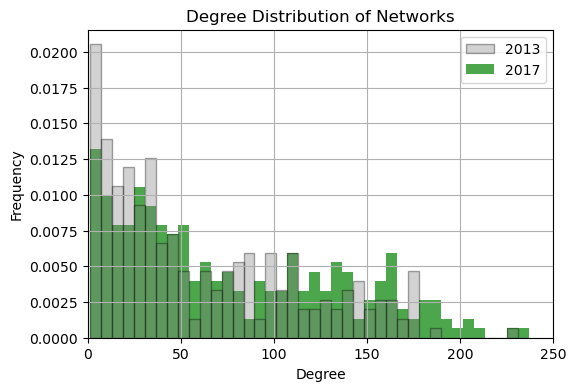

In [66]:
print("Average degree 2013:", 9757/257)
print("Average degree 2017;", 7914/257)
degree_dist_2013 = [degree for node, degree in G_2013.degree()]
degree_dist_2017 = [degree for node, degree in G_2017.degree()]

hist, bins = np.histogram(degree_dist_2013, bins=40, density=False)

# Plotting the degree distribution for network
plt.figure(figsize=(6, 4))
plt.hist(degree_dist_2013, bins=bins, density=True, alpha=0.7, color = "green")
plt.hist(degree_dist_2017, bins=bins, density=True, alpha=0.35, edgecolor = "black", color = "gray", label = "2017")
plt.legend(["2013","2017"])
plt.xlabel('Degree')
plt.xlim(0,250)
plt.ylabel('Frequency')
plt.title('Degree Distribution of Networks')
plt.grid(True)
plt.show()

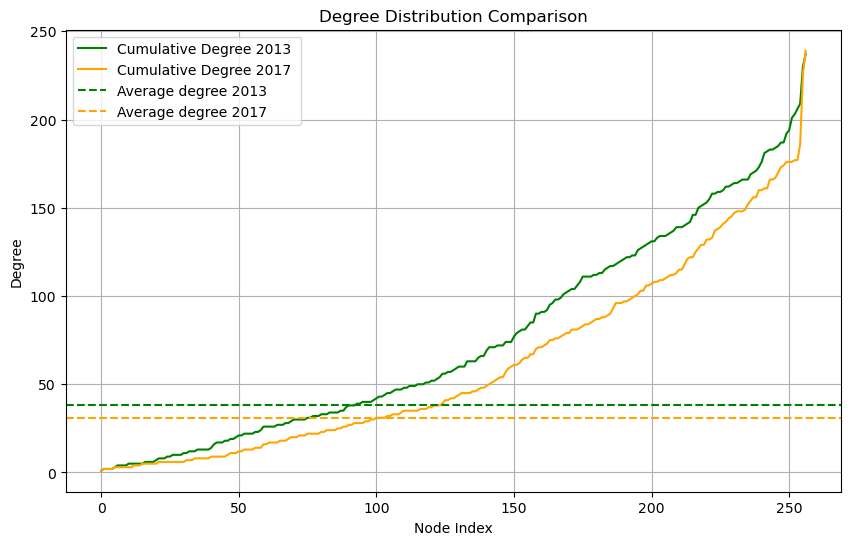

In [67]:
avg_degree_2013 = G_2013.number_of_edges()/G_2013.number_of_nodes()
avg_degree_2017 = G_2017.number_of_edges()/G_2017.number_of_nodes()
plt.figure(figsize=(10, 6))
plt.plot(sorted(degree_dist_2013), label="Cumulative Degree 2013", color="green")
plt.plot(sorted(degree_dist_2017), label="Cumulative Degree 2017 ", color="orange")
plt.title("Degree Distribution Comparison")
plt.xlabel("Node Index")
plt.ylabel("Degree")
plt.grid(True)
plt.axhline(y=avg_degree_2013, color='green', linestyle='--', label="Average degree 2013")
plt.axhline(y=avg_degree_2017, color='orange', linestyle='--', label="Average degree 2017")
plt.legend()
plt.show()

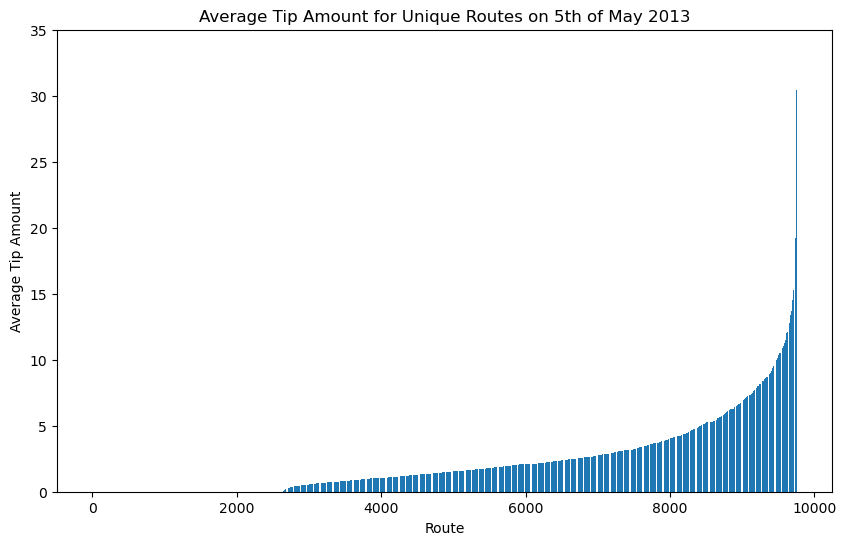

In [53]:
routes, average_tips = zip(*data[0])  # Unpack routes and average tips

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_tips)), average_tips, align='center')
plt.title('Average Tip Amount for Unique Routes on 5th of May 2013')
plt.xlabel('Route')
plt.ylabel('Average Tip Amount')
plt.ylim(0, 35)
plt.show()

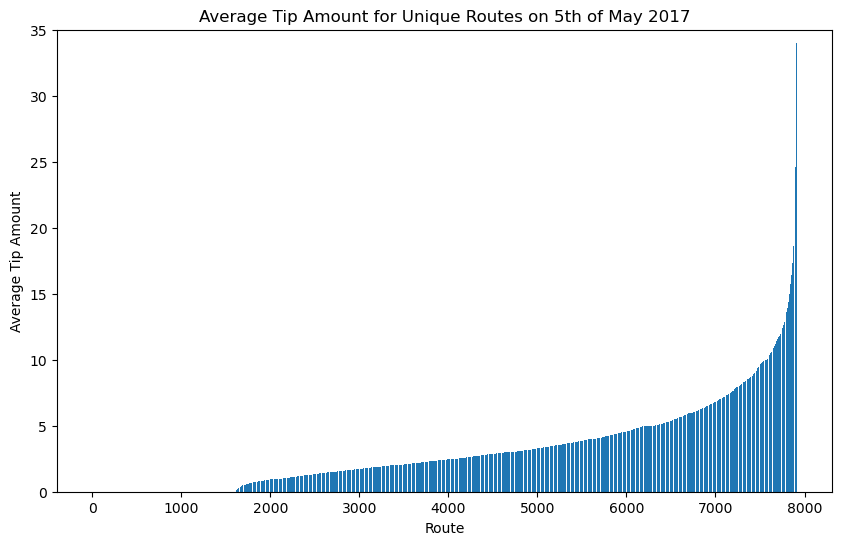

In [54]:
routes, average_tips = zip(*data[1])  # Unpack routes and average tips

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_tips)), average_tips, align='center')
plt.title('Average Tip Amount for Unique Routes on 5th of May 2017')
plt.xlabel('Route')
plt.ylabel('Average Tip Amount')
plt.ylim(0, 35)
plt.show()

In [44]:
count1 = 0
for i in data[0]:
    if i[1] > 0.0:
        count1 += 1
count2 = 0
for i in data[1]:
    if i[1] > 0.0:
        count2 += 1
print("Fraction of routes with tips in 2013:", count1/9757)
print("Fraction of routes with tips in 2017:", count2/7914)



Fraction of routes with tips in 2013: 0.7296300092241468
Fraction of routes with tips in 2017: 0.7977002779883751


### Weather Data:

In [ ]:
dictionaries = []
def process_data(date): # Method to scrape weather data based on data
    link = "https://www.wunderground.com/history/daily/us/ny/new-york-city/KLGA/date/"
    link += date

    #Selenium renders the website
    chrome_prefs = {
        "profile.default_content_settings.cookies": 1  
    }
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_experimental_option("prefs", chrome_prefs)
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get(link)
    driver.implicitly_wait(15) # Ensuring everything needed is rendered
    table = driver.find_element(By.XPATH, '//*[@id="inner-content"]/div[2]/div[1]/div[5]/div[1]/div/lib-city-history-observation/div/div[2]/table')
    rows = table.find_elements(By.TAG_NAME, 'tr')
    rows.pop(0)
    weather_data = {}
    attributes = ['Temperature', 'Dew Point', 'Humidity', 'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Precip.', 'Condition'] 
    
    for row in rows:
        if(len(row.text)>3):
            parts = row.text.strip().split(" ")
            
            time = ' '.join(parts[:2])
            details = {
                attributes[0]: parts[2] + ' ' + parts[3],  # Temperature
                attributes[1]: parts[4] + ' ' + parts[5],  # Dew Point
                attributes[2]: parts[6] + ' ' + parts[7],  # Humidity
                attributes[3]: parts[8],                   # Wind
                attributes[4]: parts[9],                   # Wind Speed
                attributes[5]: parts[11],                  # Wind Gust
                attributes[6]: parts[13] + ' ' + parts[14],# Pressure
                attributes[7]: parts[15] + ' ' + parts[16],# Precip.
                attributes[8]: ' '.join(parts[17:]) # Condition
                }
            weather_data[time] = details
    driver.quit()
    dictionaries.append(weather_data)    

In [ ]:
dates = []
for i in range(31):
    day = i+1
    process_data("2013-5-"+str(day)) # We manually change the year, since there are some issues with selenium, e.g. site blocking requests

In [ ]:
#The code below changes the format, so the weather data can more easily be used:
annual_data = {}
for i in range(11):
    year = 2013+i
    count = 0
    annual_data[str(year)] = {}
    for day in dictionaries:
        count += 1
        annual_data[str(year)][str(count)] = day
    year += i

In [ ]:
with open("transformed_data.json", "w") as file: #Saves the weather data, so it is not required to scrape everytime. 
    json.dump(annual_data,file, indent = 4)

In [ ]:
#Loads saved weather_data
with open('transformed_data.json', 'r') as file:
    data = json.load(file)

#This code simply finds the average for a given day
average_per_year = []
for year in data.items():
    average_per_month = []
    for day in year[1].items():
        sum = 0.0
        for time in day[1].items():
            precip = time[1]["Precip."].strip("in").strip(" ")
            sum += float(precip)
        average = float(sum/len(day))
        average_per_month.append(average)
    average_per_year.append(average_per_month)

#This code finds the maximum difference for each day in Precipitation between the years.
max_difference = []
for j in range(len(average_per_year[0])):
    temp_max = 0.0
    max_index = []
    temp_min = 1.0
    min_index = []
    for i in range(len(average_per_year)):
        if (float(average_per_year[i][j]) > temp_max):
            temp_max = average_per_year[i][j]
            max_index = [2013+i,1+j]
        if float(average_per_year[i][j]) < temp_min:
            temp_min = average_per_year[i][j]
            min_index = [2013+i,1+j]
    difference = temp_max-temp_min
    max_difference.append([difference,max_index,min_index])
print(max_difference)

### Wikipedia Text Data:

In [51]:
#Url dictionary holding the wikipedia pages we found based on looking at each borough's page.
urls = {
    "Bronx": ["https://en.wikipedia.org/wiki/The_Bronx","https://en.wikipedia.org/wiki/Co-op_City,_Bronx","https://en.wikipedia.org/wiki/Yankee_Stadium", "https://en.wikipedia.org/wiki/Bronx_Zoo", "https://en.wikipedia.org/wiki/Bronx_Museum_of_the_Arts", "https://en.wikipedia.org/wiki/The_Hub,_Bronx", "https://en.wikipedia.org/wiki/Morris_Heights,_Bronx","https://en.wikipedia.org/wiki/Pelham_Bay_Park","https://en.wikipedia.org/wiki/Van_Cortlandt_Park","https://en.wikipedia.org/wiki/Bronx_Park","https://en.wikipedia.org/wiki/Crotona_Park","https://en.wikipedia.org/wiki/St._Mary%27s_Park_(Bronx)","https://en.wikipedia.org/wiki/St._James_Park_(Bronx)","https://en.wikipedia.org/wiki/Macombs_Dam_Park","https://en.wikipedia.org/wiki/Henry_Hudson_Park","https://en.wikipedia.org/wiki/Ferry_Point_Park","https://en.wikipedia.org/wiki/Soundview_Park_(Bronx)","https://en.wikipedia.org/wiki/Pregones_Theater","https://en.wikipedia.org/wiki/Bronx_Academy_of_Arts_and_Dance","https://en.wikipedia.org/wiki/Fordham_Road","https://en.wikipedia.org/wiki/Bay_Plaza_Shopping_Center"], 
    "Brooklyn": ["https://en.wikipedia.org/wiki/Brooklyn","https://en.wikipedia.org/wiki/Downtown_Brooklyn","https://en.wikipedia.org/wiki/Brooklyn_Bridge","https://en.wikipedia.org/wiki/Coney_Island","https://en.wikipedia.org/wiki/Brooklyn_Museum", "https://en.wikipedia.org/wiki/Brooklyn_Borough_Hall","https://en.wikipedia.org/wiki/Barclays_Center","https://en.wikipedia.org/wiki/Brooklyn_College","https://en.wikipedia.org/wiki/Greenpoint,_Brooklyn","https://en.wikipedia.org/wiki/Sunset_Park,_Brooklyn","https://en.wikipedia.org/wiki/Eighth_Avenue_(Brooklyn)#Chinatown","https://en.wikipedia.org/wiki/Brooklyn_Botanic_Garden","https://en.wikipedia.org/wiki/Grand_Army_Plaza","https://en.wikipedia.org/wiki/The_Brooklyn_Tower","https://en.wikipedia.org/wiki/Floyd_Bennett_Field","https://en.wikipedia.org/wiki/New_York_Transit_Museum","https://en.wikipedia.org/wiki/Prospect_Park_(Brooklyn)","https://en.wikipedia.org/wiki/Prospect_Park_Zoo","https://en.wikipedia.org/wiki/Fort_Greene_Park"],
    "Manhattan":["https://en.wikipedia.org/wiki/Manhattan", "https://en.wikipedia.org/wiki/American_Museum_of_Natural_History", "https://en.wikipedia.org/wiki/The_Battery_(Manhattan)", "https://en.wikipedia.org/wiki/Broadway_(Manhattan)", "https://en.wikipedia.org/wiki/Theater_District,_Manhattan", "https://en.wikipedia.org/wiki/Bryant_Park", "https://en.wikipedia.org/wiki/Central_Park", "https://en.wikipedia.org/wiki/Chinatown,_Manhattan", "https://en.wikipedia.org/wiki/Chrysler_Building", "https://en.wikipedia.org/wiki/The_Cloisters", "https://en.wikipedia.org/wiki/Columbia_University", "https://en.wikipedia.org/wiki/Empire_State_Building", "https://en.wikipedia.org/wiki/Flatiron_Building", "https://en.wikipedia.org/wiki/Financial_District,_Manhattan", "https://en.wikipedia.org/wiki/New_York_Stock_Exchange_Building", "https://en.wikipedia.org/wiki/Wall_Street", "https://en.wikipedia.org/wiki/Greenwich_Village", "https://en.wikipedia.org/wiki/New_York_University","https://en.wikipedia.org/wiki/Harlem", "https://en.wikipedia.org/wiki/Koreatown,_Manhattan", "https://en.wikipedia.org/wiki/Lincoln_Center", "https://en.wikipedia.org/wiki/Metropolitan_Museum_of_Art", "https://en.wikipedia.org/wiki/Pennsylvania_Station_(New_York_City)", "https://en.wikipedia.org/wiki/National_September_11_Museum", "https://en.wikipedia.org/wiki/World_Trade_Center_(2001%E2%80%93present)", "https://en.wikipedia.org/wiki/Times_Square","https://en.wikipedia.org/wiki/Rockefeller_Center"],
    "Queens": ["https://en.wikipedia.org/wiki/Queens","https://en.wikipedia.org/wiki/Flushing,_Queens","https://en.wikipedia.org/wiki/Elmhurst,_Queens#Chinatown,_Elmhurst_(%E5%94%90%E4%BA%BA%E8%A1%97,_%E8%89%BE%E5%A7%86%E8%B5%AB%E6%96%AF%E7%89%B9)", "https://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport", "https://en.wikipedia.org/wiki/Flushing_Meadows%E2%80%93Corona_Park", "https://en.wikipedia.org/wiki/LaGuardia_Airport", "https://en.wikipedia.org/wiki/Downtown_Flushing", "https://en.wikipedia.org/wiki/St._Albans,_Queens#Addisleigh_Park_subsection","https://en.wikipedia.org/wiki/Long_Island_City", "https://en.wikipedia.org/wiki/Queensboro_Bridge", "https://en.wikipedia.org/wiki/Citi_Field", "https://en.wikipedia.org/wiki/Arthur_Ashe_Stadium", "https://en.wikipedia.org/wiki/Queens_Public_Library", "https://en.wikipedia.org/wiki/St._Michael%27s_Cemetery_(New_York)","https://en.wikipedia.org/wiki/All_Faiths_Cemetery","https://en.wikipedia.org/wiki/Calvary_Cemetery_(Queens)", "https://en.wikipedia.org/wiki/Cypress_Hills_Cemetery", "https://en.wikipedia.org/wiki/Mount_Olivet_Cemetery_(Queens)", "https://en.wikipedia.org/wiki/Mount_Zion_Cemetery_(New_York_City)","https://en.wikipedia.org/wiki/Jackson_Heights,_Queens"],
    "Staten Island":["https://en.wikipedia.org/wiki/Staten_Island","https://en.wikipedia.org/wiki/Verrazzano-Narrows_Bridge","https://en.wikipedia.org/wiki/Staten_Island_Zoo","https://en.wikipedia.org/wiki/Staten_Island_Ferry","https://en.wikipedia.org/wiki/College_of_Staten_Island","https://en.wikipedia.org/wiki/Historic_Richmond_Town","https://en.wikipedia.org/wiki/Staten_Island_Borough_Hall","https://en.wikipedia.org/wiki/Great_Kills_Park", "https://en.wikipedia.org/wiki/Miller_Field_(Staten_Island)","https://en.wikipedia.org/wiki/Fort_Wadsworth", "https://en.wikipedia.org/wiki/Conference_House_Park", "https://en.wikipedia.org/wiki/Willowbrook_Park", "https://en.wikipedia.org/wiki/Empire_Outlets","https://en.wikipedia.org/wiki/St._George_Terminal","https://en.wikipedia.org/wiki/Postcards_(memorial)","https://en.wikipedia.org/wiki/Sailors%27_Snug_Harbor","https://en.wikipedia.org/wiki/SIUH_Community_Park"],
}

# This code scrapes the wikipedia pages for each borough and stores the text in a list
boroughs_info = []
for info in urls.items():
    temp_text=""
    for url in info[1]:
        page = ""
        r = requests.get(url)
        soup = BeautifulSoup(r.content)
        texts = soup.find_all("p")
        for text in texts:
            page += text.text
        temp_text += page
    boroughs_info.append(temp_text)

In [54]:
# Function to clean text using NLTK. This function will be used to clean the text from the Wikipedia pages.
def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add custom words to stop words to remove them from the text
    stop_words.update(["new", "new work", "york city", "york", "bronx", "brooklyn", 
                       "manhattan", "queen", "staten island", "city", "nyc","queens", "staten", "island",])
    # Tokenize the text
    words = nltk.word_tokenize(text)

    filtered_words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words)

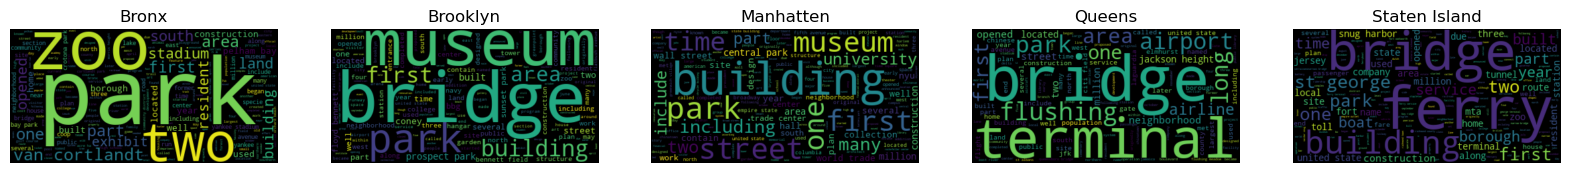

In [55]:
# Creating the wordclouds for each borough based on the text from the Wikipedia pages
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

titles = ['Bronx', 'Brooklyn', 'Manhatten', 'Queens', 'Staten Island']
temp_ = boroughs_info.copy()

for i in range(5):
    temp_[i] = clean_text(temp_[i])
    temp_[i] = temp_[i].split(" ")
    wc = wordcloud.WordCloud().generate(' '.join(temp_[i]))
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(titles[i])
plt.show() 